In [16]:
pip install medmnist torch torchvision tqdm matplotlib ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]
Note: you may need to restart the kernel to use updated packages.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from medmnist import OrganMNIST3D
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
971
Image shape: (1, 28, 28, 28)
Label: [3]


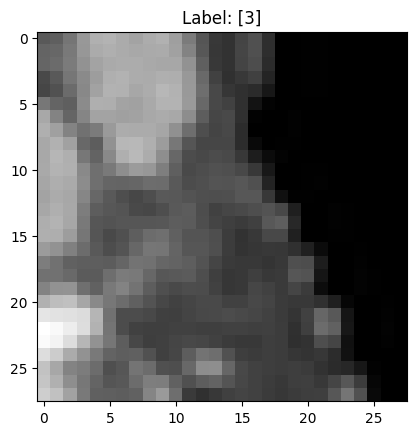

In [18]:
dataset = OrganMNIST3D(split="train", download=True)
print(len(dataset))
img, label = dataset[0]
print("Image shape:", img.shape)
print("Label:", label)

# visualize a slice of the 3D image
plt.imshow(img[0, :, :, 14], cmap='gray')
plt.title(f"Label: {label}")
plt.show()


In [19]:
print(len(dataset))            # number of samples
print(dataset[0][0].shape)     # image shape (e.g., (1, 28, 28, 28))
print(dataset[0][1])           # corresponding label


971
(1, 28, 28, 28)
[3]


In [20]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = OrganMNIST3D(split='train', transform=data_transform, download=True)
val_dataset   = OrganMNIST3D(split='val', transform=data_transform, download=True)
test_dataset  = OrganMNIST3D(split='test', transform=data_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz


In [21]:
class Simple3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 8, 3, padding=1)
        self.pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(8, 16, 3, padding=1)
        self.fc = nn.Linear(16 * 7 * 7 * 7, 11)  # 11 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Simple3DCNN().to(device)
model



Simple3DCNN(
  (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc): Linear(in_features=5488, out_features=11, bias=True)
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).squeeze()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoc [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.4f}")



ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [15]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).squeeze()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")


ValueError: pic should be 2/3 dimensional. Got 4 dimensions.